# Table of Contents

1. [Introduction](#1-introduction)  
   - [1.1 What this notebook covers](#11-what-this-notebook-covers)  
   - [1.2 Why this topic or project matters](#12-why-this-topic-or-project-matters)  

2. [Background](#2-background)  
   - [2.1 Fundamentals of network analysis](#21-fundamentals-of-network-analysis)  
       * Nodes, edges, weighted graphs, basic metrics (degree, centrality)  
   - [2.2 Co-occurrence as a proxy for semantic proximity](#22-co-occurrence-as-a-proxy-for-semantic-proximity)  
       * Why raw co-mentions can reveal thematic structure  
   - [2.3 Concept extraction in NLP](#23-concept-extraction-in-nlp)  
       * Supervised labeling (Watson NLU, spaCy, TF-IDF keywords) vs. unsupervised keyphrase methods  
   - [2.4 Comparison to other exploratory methods](#24-comparison-to-other-exploratory-methods)  
       * Topic modeling (LDA/BERTopic) vs. graph-based mapping  
       * Embedding-based similarity graphs  

3. [Objectives](#3-objectives)  
   - [3.1 What this notebook will demonstrate](#31-what-this-notebook-will-demonstrate)  
   - [3.2 Expected outcomes of the analysis](#32-expected-outcomes-of-the-analysis)  

4. [Setup](#4-setup)  
   - [4.1 Install/import libraries](#41-installimport-libraries)  
   - [4.2 Load and preview data](#42-load-and-preview-data)  

5. [Preprocessing](#5-preprocessing)  
   - [5.1 Data cleaning & concept filtering](#51-data-cleaning--concept-filtering)  
       * 5.1.1 Filtering by relevance, taxonomy & manual overrides  
       * 5.1.2 Normalizing strings & deduplication  
   - [5.2 Create initial DataFrames or dictionaries](#52-create-initial-dataframes-or-dictionaries)  
       * One for counts, one for edges (with weights)

6. [Graph Construction](#6-graph-construction)  
   - [6.1 Building the graph using NetworkX](#61-building-the-graph-using-networkx)  
     - [6.1.1 `nx.Graph` vs `nx.DiGraph` with weighted edges](#611-nxgraph-vs-nxdigraph-with-weighted-edges)  
   - [6.2 Directed vs undirected, weights, labels, etc.](#62-directed-vs-undirected-weights-labels-etc)  
   - [6.3 Visualizations (layout, color by emotion or function)](#63-visualizations-layout-color-by-emotion-or-function)  

7. [Graph Analysis](#7-graph-analysis)  
   - [7.1 Centrality, clustering, shortest paths, connected components](#71-centrality-clustering-shortest-paths-connected-components)  
   - [7.2 Subgraph exploration (e.g., emotion-specific clusters)](#72-subgraph-exploration-eg-emotion-specific-clusters)  

8. [Advanced Visualization](#8-advanced-visualization)  
   - [8.1 Using pyvis, Plotly, or enhanced NetworkX visuals](#81-using-pyvis-plotly-or-enhanced-networkx-visuals)  
   - [8.2 Interactive graph options](#82-interactive-graph-options)  

9. [Insights & Interpretation](#9-insights--interpretation)  
   - [9.1 What the graph reveals about emotional triggers, semantic structure, or Jakobsonian functions](#91-what-the-graph-reveals-about-emotional-triggers-semantic-structure-or-jakobsonian-functions)  
   - [9.2 Surprising or significant findings](#92-surprising-or-significant-findings)  

10. [Conclusion](#10-conclusion)  
    - [10.1 Summary of learnings](#101-summary-of-learnings)  
    - [10.2 Next steps or extensions](#102-next-steps-or-extensions)  

11. [Appendix (Optional)](#11-appendix-optional)  
    - [11.1 Notes on concept embeddings, model details, references](#111-notes-on-concept-embeddings-model-details-references)  
    - [11.2 Runtime notes, parameter tweaks](#112-runtime-notes-parameter-tweaks)  


### 1. Introduction

##### 1.1 What this notebook covers

In this notebook, we’ll explore how labeled concepts co-occur across a corpus to reveal thematic structures, key connectors, and emerging patterns. We’ll:

- **Extract concepts** using IBM Watson NLU (a supervised model trained on human-annotated data).  
- **Build an unsupervised co-occurrence network** by counting how often each pair of concepts appears together.  
- **Visualize and analyze** the resulting graph to generate hypotheses such as “Do concepts in the ‘care’ category cluster tightly?” or “Which ideas serve as bridges between topics?”

This workflow transforms raw NLU output into an interpretable map of concept relationships, setting the stage for deeper community detection or downstream graph analyses.

##### 1.2 Why this topic/project matters

Co-occurrence graphs are widely used to make sense of large text collections. They help practitioners:

| Role / Industry                | Purpose                                                                                         |
|--------------------------------|-------------------------------------------------------------------------------------------------|
| **Text-mining researchers**    | Map topic structures in news archives, academic papers, or survey responses.                    |
| **Data scientists & NLP teams**| Uncover hidden themes in customer feedback, social media, or support tickets.                   |
| **Digital humanists**          | Study how concepts (e.g., “war,” “peace,” “diplomacy”) cluster in historical texts.             |
| **Knowledge-management (KM)**  | Build internal concept maps to visualize how departments or documents interrelate.              |
| **Social-science researchers** | Analyze concept co-occurrence in interview transcripts or online communities.                   |

Key insights you can gain:

- **Thematic hot-spots:** Clusters of strongly connected nodes reveal major topics or concerns.  
- **Bridging concepts:** Nodes with high betweenness centrality indicate pivot ideas—ideal targets for messaging or intervention.  
- **Hidden correlations:** Unexpected pairings (e.g., “delivery” with “anxiety”) flag areas for qualitative follow-up.  
- **Trend detection:** Comparing graphs over time uncovers shifts in concept relationships.  
- **Dimensionality reduction:** Graph features (e.g., communities or embeddings) can feed into clustering or classification pipelines.

**Why your data is valuable**  
Your concepts come from human-annotated NLU, ensuring each node reflects a meaningful semantic unit. Rather than manually reviewing hundreds of documents, this network gives you a bird’s-eye view of all key terms and their interrelations, turning outliers and hubs into testable hypotheses. Plus, the same pipeline can apply to any corpus—support tickets, product reviews, legal filings, and beyond.

#### 1.3 Data scope and scalability

> **Note on sample size:**  
> In this notebook we work with a small subset of just 35 concepts so that each step (matrix builds, layout, community detection) runs instantly and the code remains easy to follow.  

> **Scalability:**  
> All of the same operations—binarizing a concept–document matrix, computing co-occurrence via sparse matrix multiplication, and running NetworkX (or graph-tool/igraph for very large graphs)—scale to thousands (or even millions) of concepts and documents. In production you’d simply switch to sparse data structures (e.g. `scipy.sparse`), a more performant graph library, and batch or distributed NLU extraction (Watson NLU, spaCy pipelines, etc.).  


---

### 2. Background

#### 2.1 Fundamentals of network analysis  
A **graph** (or network) is a mathematical structure of **nodes** (vertices) and **edges** (links). In text analysis:  
- **Nodes** represent units like words, phrases, or—here—pre-extracted concepts.  
- **Edges** represent associations (e.g. co-occurrence in the same document).  
- **Weighted edges** carry numeric values (e.g. co-occurrence counts), so stronger links stand out.

Key graph metrics:  

| Term                      | Definition                                                                             |
|---------------------------|----------------------------------------------------------------------------------------|
| **Degree**                | Number of edges connected to a node.                                                   |
| **Betweenness centrality**| Frequency a node lies on shortest paths between others—high values signal “bridges.”   |
| **Community**             | A cluster of nodes more densely connected to each other than to the rest of the graph. |
| **Layout algorithms**     | Methods (spring, circular, etc.) to arrange nodes for clearer visualization.           |

#### 2.2 Co-occurrence as a proxy for semantic proximity  
When two concepts appear together frequently, it often signals a thematic link. Raw co-mentions can uncover:  
- **Topics & subtopics:** clusters of tightly connected nodes point to major themes.  
- **Bridges & outliers:** high-betweenness nodes connect disparate themes; isolated nodes flag niche or mis-extracted terms.  
- **Evolution over time:** by slicing your data chronologically, you can track how these associations shift.

#### 2.3 Concept extraction in NLP  
Concepts can be pulled from text via:  
- **Supervised models** (Watson NLU, spaCy’s entity/concept extractors, TF-IDF keyword ranking)  
- **Unsupervised keyphrase methods** (RAKE, TextRank, YAKE)  

Use cases:  
- **Exploratory analysis:** surface major themes and emotional undertones in large corpora.  
- **Hypothesis generation:** test if, for example, “delivery” co-occurs more with “anxiety” than “satisfaction.”  
- **Feature engineering:** use node degrees or community labels in downstream classifiers (e.g. churn prediction).  
- **Emotion-aware applications:** tailor chatbots or alerts based on which emotional concepts dominate.

#### 2.4 Comparison to other exploratory methods  
- **Topic modeling (LDA, BERTopic):** probabilistic distributions of topics per document—good for broad strokes, but lacks explicit concept-to-concept links.  
- **Embedding similarity graphs:** connect concepts by semantic vector proximity—captures meaning beyond co-mentions, but requires embedding models and tuning.

> **Problem framing**  
> “Given a set of labeled concepts (with emotion tags), how can an unsupervised co-occurrence graph reveal thematic structures and emotional dynamics to inform further modeling or interventions?”


### 3. Objectives

#### 3.1 What this notebook will demonstrate

In this analysis, we will:

- **Detect hidden topic structures**  
  Apply community-detection (e.g. Louvain) to the co-occurrence network.  
  *Hypothesis:* Predefined concept groups (e.g. “care”–related terms) form distinct clusters.

- **Identify bridge concepts**  
  Measure betweenness centrality to find nodes connecting major clusters.  
  *Hypothesis:* High-betweenness nodes correspond to pivot ideas or key jargon.

- **Compare frequency vs. centrality**  
  Rank concepts by occurrence count, degree, and betweenness.  
  *Hypothesis:* The most frequent concepts are not always the most central or influential.

#### 3.2 Expected outcomes of the analysis

By the end of this notebook, you will have:

- A **visual co-occurrence graph** showing main communities and bridge nodes.  
- A **ranked table of concepts** by frequency, degree, and betweenness centrality.  
- **Community labels** for each concept, with an evaluation of alignment to known categories.  
- A list of **unexpected co-occurrences** flagged for deeper qualitative review.  
- A **reusable workflow** for exploratory concept-network analysis in any text corpus.


### 4. Setup

#### 4.1 Install/import libraries

In [1]:
from notebook_service.cli import analyze_df
from notebook_service.runner import preprocess_concepts
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import community
from itertools import combinations

pd.set_option("display.max_columns", None)

#### 4.2 Load and preview data

In [2]:
df = pd.read_csv("../data/input.csv")
nlu_df = analyze_df(df, text_column="entries")
nlu_df.head()

,entries,sadness,joy,fear,disgust,anger,concepts_raw,concepts,semantic_roles
0,"I felt anxious today, so I impulsively ordered...",0.332842,0.049939,0.104065,0.005845,0.212283,"[{'text': 'Delivery (commerce)', 'relevance': ...","[Delivery (commerce), Anxiety, Restaurant, Foo...","[(I, felt, anxious), (I, ordered, food delivery)]"
1,"After my promotion, I confidently adjusted my ...",0.074566,0.334086,0.117670,0.033797,0.014482,"[{'text': 'Retirement', 'relevance': 0.701228,...","[Retirement, Fundraising, Ageing, Old age, Soc...","[(I, adjusted, my retirement contributions)]"
2,Stress led me to overspend on shopping yesterday.,0.665364,0.122717,0.186756,0.003421,0.029566,"[{'text': 'Light-emitting diode', 'relevance':...","[Light-emitting diode, Retail, Comparison shop...","[(Stress, led, me)]"
3,Today was incredibly frustrating; I spent hour...,0.246144,0.081976,0.028637,0.018688,0.129494,"[{'text': 'Breakpoint', 'relevance': 0.748042,...","[Breakpoint, Debugger, In-circuit emulation, T...","[(Today, was, frustrating; I spent hours debug..."
4,Our sprint demo went perfectly—I’m feeling pro...,0.482779,0.598429,0.011331,0.011596,0.010271,"[{'text': 'Sprint', 'relevance': 0.873445, 'db...","[Sprint, Sprint (cycling), Flat racing, Sprint...","[(Our sprint demo, went, ), (I, ’m feeling, pr..."


### 5. Preprocessing

##### 5.1.1 Manual review of extracted concepts

> **Quality check:**  
> Automated concept extraction (e.g. via Watson NLU) can sometimes mis‐map or over‐segment terms.  
> Before computing any co-occurrences, we’ll inspect the cleaned list of 35 concepts, correct obvious mislabels or split/merge near-duplicates, and document any overrides.  
> This manual pass ensures that our network truly reflects the semantics we care about.


In [3]:
# Preprocess concepts to filter by relevance and clean up
df_concepts_final = preprocess_concepts(nlu_df, relevance_threshold=0.49)

# Inspect the result
df_concepts_final.head(10)
# df_concepts_final[["concept","relevance","typeHierarchy"]].head(10)

,doc_index,concept,relevance
0,31,Customer service,0.993362
1,24,Science,0.978561
2,31,Customer,0.964315
3,24,Computer science,0.948154
4,24,Computer,0.935257
5,6,Sleep,0.929902
6,19,Code,0.928729
7,16,Code,0.927587
8,23,Code,0.890233
9,4,Sprint,0.873445


##### 5.2 Construction of nodes and edges

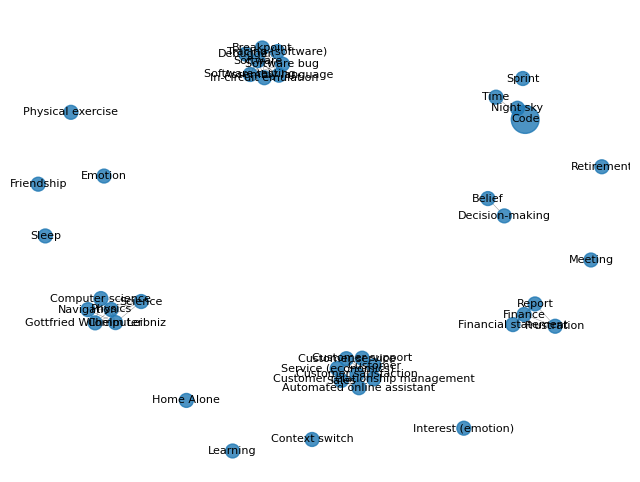

In [4]:
# 1) Group back into per‐document lists
#    df_concepts_final has one row per (doc_index, concept)


doc2concepts = (
    df_concepts_final.groupby("doc_index")["concept"].apply(list).sort_index()
)  # a Series indexed by original doc_index, each value is a list of concepts

# 2) Build the document×concept indicator matrix
mlb = MultiLabelBinarizer()
M = pd.DataFrame(
    mlb.fit_transform(doc2concepts),
    index=doc2concepts.index,
    columns=mlb.classes_,
)

# 3) Compute co‐occurrence C = Mᵀ M
C = M.T.dot(M)

# 4) Extract edges with a threshold
T = 1
edges = [
    (a, b, int(C.loc[a, b]))
    for a, b in combinations(mlb.classes_, 2)
    if C.loc[a, b] >= T
]

# 5) Build and draw the graph
G = nx.Graph()
G.add_nodes_from(mlb.classes_)
G.add_weighted_edges_from(edges)

deg_cent = nx.degree_centrality(G)
btw_cent = nx.betweenness_centrality(G, weight="weight")

pd.DataFrame(
    {"degree": pd.Series(deg_cent), "betweenness": pd.Series(btw_cent)}
).nlargest(10, "degree")


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(
    G, pos, node_size=[M[col].sum() * 100 for col in M.columns], alpha=0.8
)
nx.draw_networkx_edges(
    G,
    pos,
    width=[d["weight"] * 0.3 for _, _, d in G.edges(data=True)],
    alpha=0.5,
)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis("off")
plt.show()

In [5]:
# compute centrality scores

# degree centrality (fraction of possible neighbors that are connected)
deg_cent = nx.degree_centrality(G)

# betweenness centrality (how often a node lies on shortest paths)
btw_cent = nx.betweenness_centrality(G, weight="weight")

# put them in a DataFrame for easy viewing
df_metrics = pd.DataFrame(
    {"degree": pd.Series(deg_cent), "betweenness": pd.Series(btw_cent)}
)

# top 10 by degree
print("Top concepts by degree centrality: ")
print(df_metrics["degree"].nlargest(10), "\n")

# top 10 by betweenness
print("Top concepts by betweenness centrality: ")
df_metrics["betweenness"].nlargest(10)

# detect communities using Girvan-Newman algorithm
# Louvain or greedy modularity
communities = community.greedy_modularity_communities(G, weight="weight")

for i, comm in enumerate(communities, start=1):
    print(f"Community {i} ({len(comm)} nodes): {sorted(comm)}\n")

Top concepts by degree centrality: 
Assembly language                   0.170732
Automated online assistant          0.170732
Breakpoint                          0.170732
Customer                            0.170732
Customer relationship management    0.170732
Customer satisfaction               0.170732
Customer service                    0.170732
Customer support                    0.170732
Debugger                            0.170732
In-circuit emulation                0.170732
Name: degree, dtype: float64 

Top concepts by betweenness centrality: 
Community 1 (8 nodes): ['Automated online assistant', 'Customer', 'Customer relationship management', 'Customer satisfaction', 'Customer service', 'Customer support', 'Sales', 'Service (economics)']

Community 2 (8 nodes): ['Assembly language', 'Breakpoint', 'Debugger', 'In-circuit emulation', 'Software', 'Software bug', 'Software testing', 'Tracing (software)']

Community 3 (6 nodes): ['Computer', 'Computer science', 'Gottfried Wilhelm L

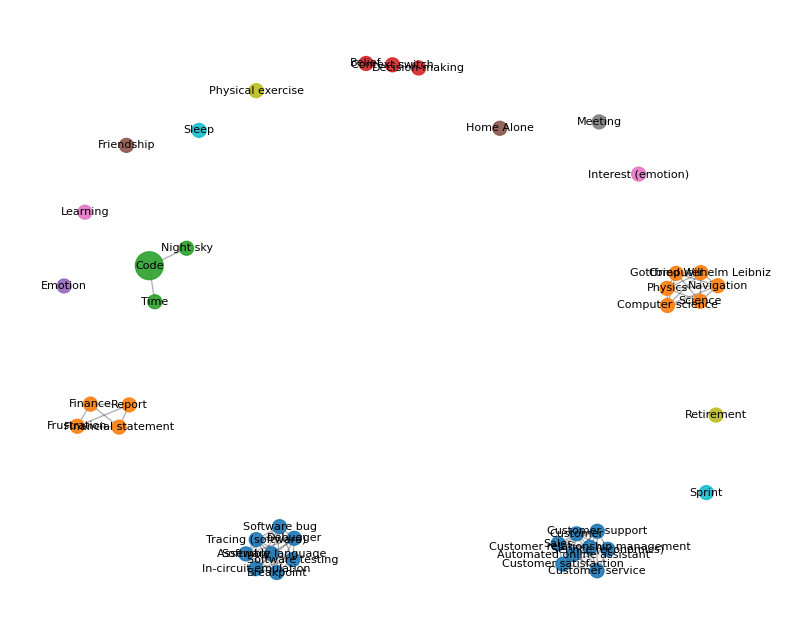

In [6]:
# color community nodes
# map each node to its community index
comm_map = {n: ci for ci, comm in enumerate(communities) for n in comm}

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=0.3)

nx.draw_networkx_nodes(
    G,
    pos,
    node_color=[comm_map[n] for n in G.nodes()],
    cmap="tab10",
    node_size=[M[col].sum() * 100 for col in M.columns],
    alpha=0.9,
)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.axis("off")
plt.show()

In [7]:
for T in [1, 2, 3, 4]:
    edges = [
        (a, b, int(C.loc[a, b]))
        for a, b in combinations(mlb.classes_, 2)
        if C.loc[a, b] >= T
    ]
    print(f"T = {T}: {len(edges)} edges")

T = 1: 80 edges
T = 2: 0 edges
T = 3: 0 edges
T = 4: 0 edges
